In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import ttest_ind

traditional_csvFile = "csv/compressed_traditional_CSV.csv"
vpTree_csvFile = "csv/compressed_VPtree_CSV.csv"
enhanced_csvFile = "csv/compressed_enhanced_CSV.csv"
cnnModel_csvFile = "csv/trained_cnn_CSV.csv"

In [211]:
# distribution of data base on size
df = pd.read_csv(enhanced_csvFile)

# Extract category from filename
df['Category'] = df['Original Image'].apply(
    lambda x: 'Glioma' if 'glioma' in x.lower() else 'Pituitary' if 'pituitary' in x.lower() else 'Unknown'
)

# Define size bins and labels
bins = [0, 40, 150, float('inf')]
labels = ['< 40 KB', '40-150 KB', '> 150 KB']

# Categorize image sizes
df['Size Category'] = pd.cut(df['Original Image Size (KB)'], bins=bins, labels=labels, right=False)

# Group by Category and Size Category
grouped = df.groupby(['Category', 'Size Category']).size().unstack(fill_value=0)

# Convert to percentages
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
percentages = percentages.round(2)

# Display the result
print("\nPercentage of Images by Category and Size Range:")
print(percentages)


Percentage of Images by Category and Size Range:
Size Category  < 40 KB  40-150 KB  > 150 KB
Category                                   
Glioma            81.0       19.0       0.0
Pituitary          9.8       89.9       0.3


C:\Users\Tristan\AppData\Local\Temp\ipykernel_21884\3206780964.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Category', 'Size Category']).size().unstack(fill_value=0)



CNN Training Summary Table:

 Epoch  Training Loss  Training Time (s)
     1       4.448427            79.0690
     2       3.447695            81.8670
     3       3.366121            83.0977
     4       3.301909            84.4567
     5       3.264943            82.7571
     6       3.242062            79.0781
     7       3.226956            78.7745
     8       3.216202            78.7636
     9       3.211485            78.6790
    10       3.206481            78.4997


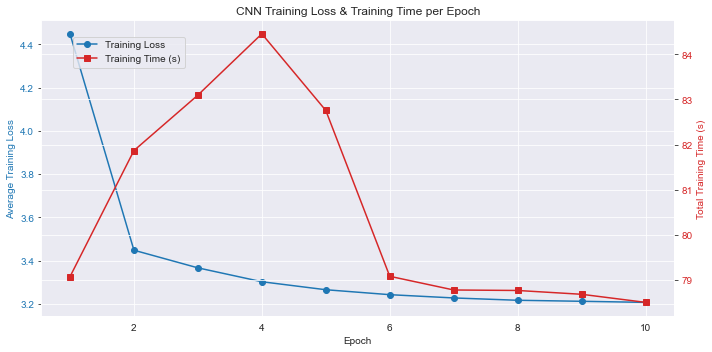

In [212]:
# CNN MODEL TRAINING TIME & ACCURACY
columns_to_display = ["Epoch", 
                      "Batch", 
                      "Training Loss", 
                      "Training Time (s)"]

try:
    # Read CSV file
    df_cnn = pd.read_csv(cnnModel_csvFile)[columns_to_display]

    # Compute the average Training Loss and total Training Time per epoch
    df_summary = df_cnn.groupby("Epoch").agg({
        "Training Loss": "mean",  # Average training loss per epoch
        "Training Time (s)": "sum"  # Total training time per epoch
    }).reset_index()

    # Display as a formatted table without tabulate
    print("\nCNN Training Summary Table:\n")
    print(df_summary.to_string(index=False))  # Clean table output

    # Set plot style
    sns.set_style("darkgrid")

    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Training Loss (left y-axis)
    color1 = "tab:blue"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Average Training Loss", color=color1)
    line1, = ax1.plot(df_summary["Epoch"], df_summary["Training Loss"], marker="o", color=color1, label="Training Loss")
    ax1.tick_params(axis="y", labelcolor=color1)

    # Create a second y-axis for Training Time
    ax2 = ax1.twinx()
    color2 = "tab:red"
    ax2.set_ylabel("Total Training Time (s)", color=color2)
    line2, = ax2.plot(df_summary["Epoch"], df_summary["Training Time (s)"], marker="s", color=color2, label="Training Time (s)")
    ax2.tick_params(axis="y", labelcolor=color2)

    # Add a legend
    fig.legend(handles=[line1, line2], loc="upper left", bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.title("CNN Training Loss & Training Time per Epoch")
    fig.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")

In [213]:
# Cross-Dataset Generalization Analysis
columns_to_display = ["Original Image", 
                      "Encoding Time (s)", 
                      "Decoding Time (s)", 
                      "PSNR (dB)", 
                      "SSIM"]

try:
    # Read the CSV file
    df = pd.read_csv(enhanced_csvFile)[columns_to_display]

    # Extract the condition (Glioma or Pituitary) from the filename
    df["Dataset"] = df["Original Image"].apply(lambda x: 
        "Glioma" if "glioma" in x.lower() else 
        "Pituitary" if "pituitary" in x.lower() else "Unknown"
    )

    # Compute the averages for each category
    df_summary = df.groupby("Dataset").agg({
        "Encoding Time (s)": "mean",
        "Decoding Time (s)": "mean",
        "PSNR (dB)": "mean",
        "SSIM": "mean"
    }).reset_index()

    print("\nMRI Image Compression Summary:\n")
    print(df_summary.to_string(index=False))  # Clean table output

    # Filter data into two groups
    glioma_data = df[df["Dataset"] == "Glioma"]
    pituitary_data = df[df["Dataset"] == "Pituitary"]

    # Store t-test results in a list
    ttest_results = []

    # Perform t-tests
    metrics_to_test = ["Encoding Time (s)", "Decoding Time (s)", "PSNR (dB)", "SSIM"]
    for metric in metrics_to_test:
        t_stat, p_value = ttest_ind(glioma_data[metric], pituitary_data[metric], equal_var=False)
        result = {
            "Metric": metric,
            "T-Statistic": round(t_stat, 4),
            "P-Value": round(p_value, 4),
            "Significant?": "Yes" if p_value < 0.05 else "No"
        }
        ttest_results.append(result)

    # Create and display a table of t-test results
    ttest_df = pd.DataFrame(ttest_results)

    print("\nT-Test Results (Glioma vs Pituitary):\n")
    print(ttest_df.to_string(index=False))

except Exception as e:
    print("An error occurred:", e)


MRI Image Compression Summary:

  Dataset  Encoding Time (s)  Decoding Time (s)  PSNR (dB)     SSIM
   Glioma           0.621558           0.037335  26.275318 0.864595
Pituitary           0.767804           0.037471  24.414191 0.805749

T-Test Results (Glioma vs Pituitary):

           Metric  T-Statistic  P-Value Significant?
Encoding Time (s)     -38.6704   0.0000          Yes
Decoding Time (s)      -0.6209   0.5347           No
        PSNR (dB)      35.8166   0.0000          Yes
             SSIM      42.2377   0.0000          Yes


In [214]:
# COMPARISON | traditional vs proposed | compression time and ratio
# Columns to compare
columns_to_compare = ["Original Image", 
                      "Encoding Time (s)", 
                      "Decoding Time (s)", 
                      "Original Image Size (KB)", 
                      "Compressed Image Size (KB)", 
                      "Compression Ratio"]

try:
    # Read CSV files
    df_traditional = pd.read_csv(traditional_csvFile)[columns_to_compare]
    df_enhanced = pd.read_csv(enhanced_csvFile)[columns_to_compare]

    # Rename columns for clarity
    df_traditional = df_traditional.rename(columns=lambda x: f"Traditional {x}" if x != "Original Image" else x)
    df_enhanced = df_enhanced.rename(columns=lambda x: f"Enhanced {x}" if x != "Original Image" else x)

    # Merge data on "Original Image"
    comparison_df = pd.merge(df_traditional, df_enhanced, on="Original Image")
    comparison_df = comparison_df.rename(columns={"Original Image": "Image Names"})

    # Reorder columns for side-by-side comparison
    ordered_columns = [
        "Image Names",
        "Traditional Encoding Time (s)", "Enhanced Encoding Time (s)",
        "Traditional Decoding Time (s)", "Enhanced Decoding Time (s)",
        "Traditional Original Image Size (KB)", "Enhanced Original Image Size (KB)",
        "Traditional Compressed Image Size (KB)", "Enhanced Compressed Image Size (KB)",
        "Traditional Compression Ratio", "Enhanced Compression Ratio"
    ]
    comparison_df = comparison_df[ordered_columns]

    # Display the first 5 rows
    display(comparison_df.head(5))

except FileNotFoundError as e:
    print(f"Error: {e}")


,Image Names,Traditional Encoding Time (s),Enhanced Encoding Time (s),Traditional Decoding Time (s),Enhanced Decoding Time (s),Traditional Original Image Size (KB),Enhanced Original Image Size (KB),Traditional Compressed Image Size (KB),Enhanced Compressed Image Size (KB),Traditional Compression Ratio,Enhanced Compression Ratio
0,glioma_0001.jpg,107.9857,0.8457,0.1107,0.0676,40.51,40.51,7.70,7.34,1:5,1:5
1,glioma_0002.jpg,114.4855,0.7641,0.0158,0.0354,45.25,45.25,8.53,8.10,1:5,1:5
2,glioma_0003.jpg,113.5626,0.6732,0.0158,0.0365,34.63,34.63,6.52,6.19,1:5,1:5
3,glioma_0004.jpg,118.0764,0.4882,0.0000,0.0345,32.02,32.02,5.96,5.70,1:5,1:5
4,glioma_0005.jpg,118.3600,0.5764,0.0075,0.0467,28.20,28.20,5.33,5.04,1:5,1:5


In [215]:
# COMPARISON | traditional vs proposed | image quality
# Columns to compare
columns_to_compare = ["Original Image", 
                      "Original Image Path", 
                      "Compressed Image Path", 
                      "PSNR (dB)", 
                      "SSIM"]

try:
    # Read CSV files
    df_traditional = pd.read_csv(traditional_csvFile)[columns_to_compare]
    df_enhanced = pd.read_csv(enhanced_csvFile)[columns_to_compare]

    # Rename columns for clarity
    df_traditional = df_traditional.rename(columns=lambda x: f"Traditional {x}" if x != "Original Image" else x)
    df_enhanced = df_enhanced.rename(columns=lambda x: f"Enhanced {x}" if x != "Original Image" else x)

    # Merge data on "Original Image"
    comparison_df = pd.merge(df_traditional, df_enhanced, on="Original Image")

    # Remove "data/" prefix from paths
    for col in ["Traditional Original Image Path", "Traditional Compressed Image Path", "Enhanced Compressed Image Path"]:
        comparison_df[col] = comparison_df[col].str.replace(r"^data/", "", regex=True)

    # Function to format Image Name + Image in one column
    def format_image_name(image_name, path):
        return f'<div style="text-align: center;"><b>{image_name}</b><br><img src="{path}" width="100"/></div>'

    # Apply the function to combine "Image Names" and "Original Image"
    comparison_df["Image Info"] = comparison_df.apply(lambda row: format_image_name(row["Original Image"], row["Traditional Original Image Path"]), axis=1)

    # Convert compressed image paths into images
    def path_to_img_html(path):
        return f'<img src="{path}" width="100"/>'

    comparison_df["Traditional Compressed Image"] = comparison_df["Traditional Compressed Image Path"].apply(path_to_img_html)
    comparison_df["Enhanced Compressed Image"] = comparison_df["Enhanced Compressed Image Path"].apply(path_to_img_html)

    # Reorder columns for side-by-side comparison
    ordered_columns = [
        "Image Info",  # Combined "Image Names" and "Original Image"
        "Traditional Compressed Image", "Enhanced Compressed Image",
        "Traditional PSNR (dB)", "Enhanced PSNR (dB)",
        "Traditional SSIM", "Enhanced SSIM"
    ]
    comparison_df = comparison_df[ordered_columns]

    # Display DataFrame as HTML with images
    display(HTML(comparison_df.head(5).to_html(escape=False)))

except FileNotFoundError as e:
    print(f"Error: {e}")

,Image Info,Traditional Compressed Image,Enhanced Compressed Image,Traditional PSNR (dB),Enhanced PSNR (dB),Traditional SSIM,Enhanced SSIM
0,glioma_0001.jpg,,,39.3766,24.0305,0.9752,0.8260
1,glioma_0002.jpg,,,38.6396,23.9329,0.9727,0.8028
2,glioma_0003.jpg,,,40.8086,28.0477,0.9780,0.8794
3,glioma_0004.jpg,,,40.1508,25.2129,0.9801,0.8779
4,glioma_0005.jpg,,,42.0036,27.9213,0.9825,0.8966


In [216]:
# COMPARISON | vp-tree vs proposed | compression time and ratio
# Columns to compare
columns_to_compare = ["Original Image", 
                      "Encoding Time (s)", 
                      "Decoding Time (s)", 
                      "Original Image Size (KB)", 
                      "Compressed Image Size (KB)", 
                      "Compression Ratio"]

try:
    # Read CSV files
    df_VPtree = pd.read_csv(vpTree_csvFile)[columns_to_compare]
    df_enhanced = pd.read_csv(enhanced_csvFile)[columns_to_compare]

    # Rename columns for clarity
    df_VPtree = df_VPtree.rename(columns=lambda x: f"VP-tree {x}" if x != "Original Image" else x)
    df_enhanced = df_enhanced.rename(columns=lambda x: f"Enhanced {x}" if x != "Original Image" else x)

    # Merge data on "Original Image"
    comparison_df = pd.merge(df_VPtree, df_enhanced, on="Original Image")
    comparison_df = comparison_df.rename(columns={"Original Image": "Image Names"})

    # Reorder columns for side-by-side comparison
    ordered_columns = [
        "Image Names",
        "VP-tree Encoding Time (s)", "Enhanced Encoding Time (s)",
        "VP-tree Decoding Time (s)", "Enhanced Decoding Time (s)",
        "VP-tree Original Image Size (KB)", "Enhanced Original Image Size (KB)",
        "VP-tree Compressed Image Size (KB)", "Enhanced Compressed Image Size (KB)",
        "VP-tree Compression Ratio", "Enhanced Compression Ratio"
    ]
    comparison_df = comparison_df[ordered_columns]

    # Display the first 5 rows
    display(comparison_df.head(5))

except FileNotFoundError as e:
    print(f"Error: {e}")

,Image Names,VP-tree Encoding Time (s),Enhanced Encoding Time (s),VP-tree Decoding Time (s),Enhanced Decoding Time (s),VP-tree Original Image Size (KB),Enhanced Original Image Size (KB),VP-tree Compressed Image Size (KB),Enhanced Compressed Image Size (KB),VP-tree Compression Ratio,Enhanced Compression Ratio
0,glioma_0001.jpg,0.5130,0.8457,0.0825,0.0676,40.51,40.51,7.08,7.34,1:5,1:5
1,glioma_0002.jpg,0.1351,0.7641,0.0369,0.0354,45.25,45.25,7.79,8.10,1:5,1:5
2,glioma_0003.jpg,0.0752,0.6732,0.0402,0.0365,34.63,34.63,6.02,6.19,1:5,1:5
3,glioma_0004.jpg,0.2569,0.4882,0.0369,0.0345,32.02,32.02,5.53,5.70,1:5,1:5
4,glioma_0005.jpg,0.2244,0.5764,0.0333,0.0467,28.20,28.20,4.87,5.04,1:5,1:5


In [217]:
# COMPARISON | vp-tree vs proposed | image quality
# Columns to compare
columns_to_compare = ["Original Image", 
                      "Original Image Path", 
                      "Compressed Image Path", 
                      "PSNR (dB)", 
                      "SSIM"]

try:
    # Read CSV files
    df_VPtree = pd.read_csv(vpTree_csvFile)[columns_to_compare]
    df_enhanced = pd.read_csv(enhanced_csvFile)[columns_to_compare]

    # Rename columns for clarity
    df_VPtree = df_VPtree.rename(columns=lambda x: f"VP-tree {x}" if x != "Original Image" else x)
    df_enhanced = df_enhanced.rename(columns=lambda x: f"Enhanced {x}" if x != "Original Image" else x)

    # Merge data on "Original Image"
    comparison_df = pd.merge(df_VPtree, df_enhanced, on="Original Image")

    # Remove "data/" prefix from paths
    for col in ["VP-tree Original Image Path", "VP-tree Compressed Image Path", "Enhanced Compressed Image Path"]:
        comparison_df[col] = comparison_df[col].str.replace(r"^data/", "", regex=True)

    # Function to format Image Name + Image in one column
    def format_image_name(image_name, path):
        return f'<div style="text-align: center;"><b>{image_name}</b><br><img src="{path}" width="100"/></div>'

    # Apply the function to combine "Image Names" and "Original Image"
    comparison_df["Image Info"] = comparison_df.apply(lambda row: format_image_name(row["Original Image"], row["VP-tree Original Image Path"]), axis=1)

    # Convert compressed image paths into images
    def path_to_img_html(path):
        return f'<img src="{path}" width="100"/>'

    comparison_df["VP-tree Compressed Image"] = comparison_df["VP-tree Compressed Image Path"].apply(path_to_img_html)
    comparison_df["Enhanced Compressed Image"] = comparison_df["Enhanced Compressed Image Path"].apply(path_to_img_html)

    # Reorder columns for side-by-side comparison
    ordered_columns = [
        "Image Info",  # Combined "Image Names" and "Original Image"
        "VP-tree Compressed Image", "Enhanced Compressed Image",
        "VP-tree PSNR (dB)", "Enhanced PSNR (dB)",
        "VP-tree SSIM", "Enhanced SSIM"
    ]
    comparison_df = comparison_df[ordered_columns]

    # Display DataFrame as HTML with images
    display(HTML(comparison_df.head(5).to_html(escape=False)))

except FileNotFoundError as e:
    print(f"Error: {e}")

,Image Info,VP-tree Compressed Image,Enhanced Compressed Image,VP-tree PSNR (dB),Enhanced PSNR (dB),VP-tree SSIM,Enhanced SSIM
0,glioma_0001.jpg,,,22.2738,24.0305,0.7402,0.8260
1,glioma_0002.jpg,,,22.1258,23.9329,0.7152,0.8028
2,glioma_0003.jpg,,,25.5350,28.0477,0.7995,0.8794
3,glioma_0004.jpg,,,23.6932,25.2129,0.8238,0.8779
4,glioma_0005.jpg,,,25.7694,27.9213,0.8344,0.8966


In [218]:
# looking for data to be used in the paper based on [largest, mid, smallest] image size
df = pd.read_csv(enhanced_csvFile)

# Add a 'Category' column based on filename prefix
df['Category'] = df['Original Image'].apply(lambda x: 'Glioma' if 'glioma' in x.lower() else 'Pituitary' if 'pituitary' in x.lower() else 'Unknown')

# Process each category
for category in ['Glioma', 'Pituitary']:
    print(f"\n===== Category: {category} =====")
    
    df_cat = df[df['Category'] == category].copy()
    df_sorted = df_cat.sort_values(by="Original Image Size (KB)", ascending=True).reset_index(drop=True)

    # Get 5 smallest
    smallest = df_sorted.head(5).reset_index(drop=True)

    # Get 5 largest
    largest = df_sorted.tail(5).reset_index(drop=True)

    # Get 5 mid (2 before, exact middle, 2 after)
    total = len(df_sorted)
    if total >= 5:
        mid_index = total // 2
        start = max(0, mid_index - 2)
        end = min(total, mid_index + 3)
        mid = df_sorted.iloc[start:end].reset_index(drop=True)
    else:
        mid = df_sorted.iloc[[total // 2]].reset_index(drop=True)

    # Display results
    print("\nLargest:")
    for i, row in largest.iloc[::-1].reset_index(drop=True).iterrows():
        print(f"{i+1}. {row['Original Image']} - {row['Original Image Size (KB)']} KB")

    print("\nMid:")
    for i, row in mid.iterrows():
        print(f"{i+1}. {row['Original Image']} - {row['Original Image Size (KB)']} KB")

    print("\nSmallest:")
    for i, row in smallest.iterrows():
        print(f"{i+1}. {row['Original Image']} - {row['Original Image Size (KB)']} KB")

    print("\n\n")



===== Category: Glioma =====

Largest:
1. glioma_0132.jpg - 53.32 KB
2. glioma_0990.jpg - 53.23 KB
3. glioma_0322.jpg - 52.54 KB
4. glioma_0296.jpg - 52.2 KB
5. glioma_0102.jpg - 50.99 KB

Mid:
1. glioma_0840.jpg - 34.0 KB
2. glioma_0557.jpg - 34.01 KB
3. glioma_0386.jpg - 34.02 KB
4. glioma_0769.jpg - 34.04 KB
5. glioma_0159.jpg - 34.04 KB

Smallest:
1. glioma_0934.jpg - 19.43 KB
2. glioma_0171.jpg - 19.81 KB
3. glioma_0111.jpg - 19.91 KB
4. glioma_0918.jpg - 19.93 KB
5. glioma_0558.jpg - 20.02 KB




===== Category: Pituitary =====

Largest:
1. pituitary_0048.jpg - 328.59 KB
2. pituitary_0681.jpg - 266.28 KB
3. pituitary_0287.jpg - 236.31 KB
4. pituitary_0798.jpg - 147.91 KB
5. pituitary_0598.jpg - 124.3 KB

Mid:
1. pituitary_0274.jpg - 48.93 KB
2. pituitary_0873.jpg - 48.93 KB
3. pituitary_0971.jpg - 48.95 KB
4. pituitary_0816.jpg - 48.95 KB
5. pituitary_0217.jpg - 48.97 KB

Smallest:
1. pituitary_0106.jpg - 20.61 KB
2. pituitary_0249.jpg - 20.92 KB
3. pituitary_0498.jpg - 20.98 KB